# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing Libraries

In [2]:
import os
from os import path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from PIL import Image

## Unzipping the zip file

In [3]:
!unzip '/content/gdrive/MyDrive/4.2/CSE 4238/Dataset C.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training-c/c19299.png   
  inflating: training-c/c19300.png   
  inflating: training-c/c19301.png   
  inflating: training-c/c19302.png   
  inflating: training-c/c19303.png   
  inflating: training-c/c19304.png   
  inflating: training-c/c19305.png   
  inflating: training-c/c19306.png   
  inflating: training-c/c19307.png   
  inflating: training-c/c19308.png   
  inflating: training-c/c19309.png   
  inflating: training-c/c19310.png   
  inflating: training-c/c19311.png   
  inflating: training-c/c19312.png   
  inflating: training-c/c19313.png   
  inflating: training-c/c19314.png   
  inflating: training-c/c19315.png   
  inflating: training-c/c19316.png   
  inflating: training-c/c19317.png   
  inflating: training-c/c19318.png   
  inflating: training-c/c19319.png   
  inflating: training-c/c19320.png   
  inflating: training-c/c19321.png   
  inflating: training-c/c19322.png   
  inflating: training-c/c19323.png   

# Reading Data From the csv File

In [4]:
cols_csv = pd.read_csv('/content/training-c.csv')
# print(cols_csv.columns)

cols_csv.drop(cols_csv.columns[[1,2,4,5,6]], axis = 1, inplace = True)
print(cols_csv) 

cols_csv.to_csv('Datas.csv',index=False)

         filename  digit
0      c00000.png      6
1      c00001.png      1
2      c00002.png      3
3      c00003.png      2
4      c00004.png      7
...           ...    ...
24293  c24293.png      3
24294  c24294.png      2
24295  c24295.png      7
24296  c24296.png      2
24297  c24297.png      7

[24298 rows x 2 columns]


In [5]:
datas = pd.read_csv('Datas.csv')
datas.head(10) #First 5 Rows of the CSV File

,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7
5,c00005.png,3
6,c00006.png,4
7,c00007.png,7
8,c00008.png,5
9,c00009.png,3


# Converting Images and Transforming them to Train and Test

In [6]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [7]:
mean = [0.5,]
std = [0.5,]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

TRAIN_PATH = '/content/training-c'
train_data = Dataset(datas, TRAIN_PATH, train_transform)
test_data = Dataset(datas, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))
print("Trainig Samples: ",len(test_data))

Trainig Samples:  24298
Trainig Samples:  24298


# Hyperparameter Setting 4 Exp.2
*   No of hidden layers = 4
*   Hidden Nodes = 784-250-200-200-100-10
*   Iteration = 30000
*   Learning rate = 0.09
*   Batch Size = 64
*   Activation Function : ReLU,ReLU6
*   Optimizer : SGD
*   Accuracy : 76.74%

In [18]:
batch_size = 64
num_iters = 30000
input_dim = 28*28
output_dim = 10
learning_rate = 0.09
num_hidden = 250  #number of hidden nodes
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# split data 20% for testing
test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:304
Test dataloader:76


In [19]:
num_epochs = num_iters / (len(train_idx) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


98


# Creating Neural Network Model

In [26]:

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 28*28 --> 250
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU6()

        ### 2nd hidden layer: 200 --> 200
        self.linear_2 = nn.Linear(num_hidden, 200)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU6()

        ### 3rd hidden layer: 200 --> 200
        self.linear_3 = nn.Linear(200, 200)
        ## Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 200 --> 200
        self.linear_4 = nn.Linear(200, 100)
        ## Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()


        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ## Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ## Non-linearity in 4th hidden layer
        out = self.relu_4(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [27]:

'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=250, bias=True)
  (relu_1): ReLU6()
  (linear_2): Linear(in_features=250, out_features=200, bias=True)
  (relu_2): ReLU6()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=100, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

# Optimizer (SGD)

In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [29]:

iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3045432567596436. Accuracy: 9.734513274336283
Iteration: 1000. Loss: 2.2846662998199463. Accuracy: 10.331343897921384
Iteration: 1500. Loss: 2.2410876750946045. Accuracy: 10.26960279892982
Iteration: 2000. Loss: 2.13539457321167. Accuracy: 19.901214241613502
Iteration: 2500. Loss: 2.1110568046569824. Accuracy: 24.120189339370242
Iteration: 3000. Loss: 2.1536865234375. Accuracy: 23.626260547437745
Iteration: 3500. Loss: 2.2513527870178223. Accuracy: 30.026754476229677
Iteration: 4000. Loss: 1.9722532033920288. Accuracy: 26.301708170405433
Iteration: 4500. Loss: 2.033297538757324. Accuracy: 28.791932496398434
Iteration: 5000. Loss: 2.0898075103759766. Accuracy: 23.79090347808191
Iteration: 5500. Loss: 1.7419133186340332. Accuracy: 29.47108458530562
Iteration: 6000. Loss: 2.0822646617889404. Accuracy: 22.370858201275983
Iteration: 6500. Loss: 2.3508317470550537. Accuracy: 19.098579954723196
Iteration: 7000. Loss: 1.752310037612915. Accuracy: 27.783494546202924
Iter

# Plotting Loss Graph According to Iterations

[2.3045432567596436, 2.2846662998199463, 2.2410876750946045, 2.13539457321167, 2.1110568046569824, 2.1536865234375, 2.2513527870178223, 1.9722532033920288, 2.033297538757324, 2.0898075103759766, 1.7419133186340332, 2.0822646617889404, 2.3508317470550537, 1.752310037612915, 1.6679736375808716, 2.237637996673584, 1.921367883682251, 1.7933478355407715, 2.1922717094421387, 1.7610443830490112, 1.4209620952606201, 1.636550784111023, 1.7107617855072021, 1.4155645370483398, 1.2933599948883057, 1.4211994409561157, 1.3726165294647217, 1.2918144464492798, 1.3179452419281006, 1.5144925117492676, 2.320176124572754, 1.0148956775665283, 1.104805827140808, 1.1984045505523682, 1.0979007482528687, 0.8792952299118042, 1.1008284091949463, 1.1391265392303467, 0.9738479256629944, 0.8958184123039246, 1.158770203590393, 1.1068013906478882, 0.953294038772583, 1.0121278762817383, 1.2090193033218384, 0.9738982319831848, 0.5090106725692749, 0.7783003449440002, 0.7812178730964661, 0.6410769820213318, 0.73108738660

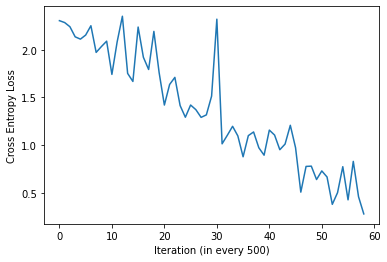

In [30]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.savefig('plot_7.png', dpi=600, bbox_inches='tight')
plt.show()

# Saving the Model

In [31]:
root_path = '/content/gdrive/MyDrive/4.2/CSE 4238/Saved Models'
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), root_path + '170104021_7.pkl') 